In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd

# URL du dataset WeatherBench 2 sur Google Cloud
url = "gs://weatherbench2/datasets/era5/1959-2023_01_10-wb13-6h-1440x721_with_derived_variables.zarr"

# Ouverture lazy (ne charge rien encore en mémoire)
ds = xr.open_zarr(url, consolidated=True)

### Température

#### Cartes

In [15]:
def plot_era5_t2m(ds, date, region=(-12.5, 42.5, 35,72), save_path=None):
    """
    Affiche la température à 2 m (T2M) depuis un dataset ERA5 pour une date donnée.

    Paramètres
    ----------
    ds : xarray.Dataset
        Dataset ERA5 contenant la variable '2m_temperature'.
    date : str
        Date au format ISO (ex. '2012-08-25T15:00:00').
    region : tuple (lon_min, lon_max, lat_min, lat_max), optionnel
        Limites géographiques de la carte (par défaut : Europe).
    save_path : str ou None, optionnel
        Chemin complet du fichier PNG à sauvegarder (ex. 'output/t2m_map.png').
        Si None, la figure est simplement affichée.

    Exemple
    -------
    >>> ds = xr.open_dataset("era5_surface.nc")
    >>> plot_era5_t2m(ds, "2012-08-25T15:00:00", region=(-10, 30, 35, 60))
    """
    
    lon_min, lon_max, lat_min, lat_max = region

    # Sélection de la date et conversion en °C
    t2m = ds["2m_temperature"].sel(time=date, method="nearest", tolerance="3H") - 273.15

    # Recentrage des longitudes sur [-180, 180]
    t2m = t2m.assign_coords(longitude=(((t2m.longitude + 180) % 360) - 180)).sortby("longitude")
    
    # --- Gestion du cas où la région traverse la discontinuité 180° ---
    if lon_min < lon_max:
        # Cas normal (région continue)
        t2m_region = t2m.sel(longitude=slice(lon_min, lon_max), latitude=slice(lat_max, lat_min))
    else:
        # Cas traversant 180° → concaténer deux morceaux
        t2m_left = t2m.sel(longitude=slice(lon_min, 180), latitude=slice(lat_max, lat_min))
        t2m_right = t2m.sel(longitude=slice(-180, lon_max), latitude=slice(lat_max, lat_min))
        t2m_region = xr.concat([t2m_left, t2m_right], dim="longitude")
    
    # Sélection de la région
    t2m_region = t2m.sel(longitude=slice(lon_min, lon_max), latitude=slice(lat_max, lat_min))

    # Projection et carte
    proj = ccrs.PlateCarree()
    fig = plt.figure(figsize=(10, 7))
    ax = plt.axes(projection=proj)
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=proj)
    
    # Tracé
    im = t2m_region.plot(
        ax=ax, transform=proj, cmap="coolwarm",
        vmin=-40, vmax=40,
        cbar_kwargs={"label": "2m temperature (°C)"}
    )
    
    # Ajout des côtes, frontières et grille
    ax.add_feature(cfeature.COASTLINE.with_scale("50m"), linewidth=0.8)
    ax.add_feature(cfeature.BORDERS.with_scale("50m"), linewidth=0.6)
    gl = ax.gridlines(draw_labels=True, linestyle="--", linewidth=0.4)
    gl.right_labels = False
    gl.top_labels = False

    plt.title(f"ERA5 — 2m temperature — {str(t2m.time.values)[:19]} UTC")
    
    # Sauvegarde ou affichage
    if save_path is not None:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
        plt.close(fig)
        print(f"Carte sauvegardée sous : {save_path}")
    else:
        plt.show()
    

##### Random date

In [18]:
date = "2012-08-25T15:00:00"

In [19]:
plot_era5_t2m(ds,date,save_path='visuels_era5/t2m_2012-08-25_europe.png')
plot_era5_t2m(ds, date, region=(-180,180,-90,90), save_path='visuels_era5/t2m_2012-08-25_monde.png')

c:\Users\arfib\anaconda3\envs\meteo_env\Lib\site-packages\xarray\core\indexes.py:631: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  flat_indexer = index.get_indexer(flat_labels, method=method, tolerance=tolerance)


Carte sauvegardée sous : visuels_era5/t2m_2012-08-25_europe.png


c:\Users\arfib\anaconda3\envs\meteo_env\Lib\site-packages\xarray\core\indexes.py:631: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  flat_indexer = index.get_indexer(flat_labels, method=method, tolerance=tolerance)


Carte sauvegardée sous : visuels_era5/t2m_2012-08-25_monde.png


##### Canicule du 11 août 2021

In [20]:
date = "2021-08-11T12:00:00"

In [21]:
plot_era5_t2m(ds,date,save_path='visuels_era5/t2m_2021-08-11_europe_canicule.png')
plot_era5_t2m(ds, date, region=(-180,180,-90,90), save_path='visuels_era5/t2m_2021-08-11_monde_canicule.png')

c:\Users\arfib\anaconda3\envs\meteo_env\Lib\site-packages\xarray\core\indexes.py:631: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  flat_indexer = index.get_indexer(flat_labels, method=method, tolerance=tolerance)


Carte sauvegardée sous : visuels_era5/t2m_2021-08-11_europe_canicule.png


c:\Users\arfib\anaconda3\envs\meteo_env\Lib\site-packages\xarray\core\indexes.py:631: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  flat_indexer = index.get_indexer(flat_labels, method=method, tolerance=tolerance)


Carte sauvegardée sous : visuels_era5/t2m_2021-08-11_monde_canicule.png


##### Vague de froid du 27 janvier au 13 février 2012

In [22]:
# Définir la période de la vague de froid
dates = pd.date_range("2012-01-27", "2012-02-13", freq="1D")

# Créer les cartes jour par jour
for date in dates:
    iso_date = date.strftime("%Y-%m-%dT12:00:00")  # milieu de journée
    output_path = f"visuels_era5/vague_froid/t2m_{date.strftime('%Y%m%d')}.png"
    plot_era5_t2m(
        ds,
        iso_date,
        save_path=output_path
    )

c:\Users\arfib\anaconda3\envs\meteo_env\Lib\site-packages\xarray\core\indexes.py:631: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  flat_indexer = index.get_indexer(flat_labels, method=method, tolerance=tolerance)


Carte sauvegardée sous : visuels_era5/vague_froid/t2m_20120127.png


c:\Users\arfib\anaconda3\envs\meteo_env\Lib\site-packages\xarray\core\indexes.py:631: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  flat_indexer = index.get_indexer(flat_labels, method=method, tolerance=tolerance)


Carte sauvegardée sous : visuels_era5/vague_froid/t2m_20120128.png


c:\Users\arfib\anaconda3\envs\meteo_env\Lib\site-packages\xarray\core\indexes.py:631: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  flat_indexer = index.get_indexer(flat_labels, method=method, tolerance=tolerance)


Carte sauvegardée sous : visuels_era5/vague_froid/t2m_20120129.png


c:\Users\arfib\anaconda3\envs\meteo_env\Lib\site-packages\xarray\core\indexes.py:631: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  flat_indexer = index.get_indexer(flat_labels, method=method, tolerance=tolerance)


Carte sauvegardée sous : visuels_era5/vague_froid/t2m_20120130.png


c:\Users\arfib\anaconda3\envs\meteo_env\Lib\site-packages\xarray\core\indexes.py:631: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  flat_indexer = index.get_indexer(flat_labels, method=method, tolerance=tolerance)


Carte sauvegardée sous : visuels_era5/vague_froid/t2m_20120131.png


c:\Users\arfib\anaconda3\envs\meteo_env\Lib\site-packages\xarray\core\indexes.py:631: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  flat_indexer = index.get_indexer(flat_labels, method=method, tolerance=tolerance)


Carte sauvegardée sous : visuels_era5/vague_froid/t2m_20120201.png


c:\Users\arfib\anaconda3\envs\meteo_env\Lib\site-packages\xarray\core\indexes.py:631: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  flat_indexer = index.get_indexer(flat_labels, method=method, tolerance=tolerance)


Carte sauvegardée sous : visuels_era5/vague_froid/t2m_20120202.png


c:\Users\arfib\anaconda3\envs\meteo_env\Lib\site-packages\xarray\core\indexes.py:631: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  flat_indexer = index.get_indexer(flat_labels, method=method, tolerance=tolerance)


Carte sauvegardée sous : visuels_era5/vague_froid/t2m_20120203.png


c:\Users\arfib\anaconda3\envs\meteo_env\Lib\site-packages\xarray\core\indexes.py:631: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  flat_indexer = index.get_indexer(flat_labels, method=method, tolerance=tolerance)


Carte sauvegardée sous : visuels_era5/vague_froid/t2m_20120204.png


c:\Users\arfib\anaconda3\envs\meteo_env\Lib\site-packages\xarray\core\indexes.py:631: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  flat_indexer = index.get_indexer(flat_labels, method=method, tolerance=tolerance)


Carte sauvegardée sous : visuels_era5/vague_froid/t2m_20120205.png


c:\Users\arfib\anaconda3\envs\meteo_env\Lib\site-packages\xarray\core\indexes.py:631: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  flat_indexer = index.get_indexer(flat_labels, method=method, tolerance=tolerance)


Carte sauvegardée sous : visuels_era5/vague_froid/t2m_20120206.png


c:\Users\arfib\anaconda3\envs\meteo_env\Lib\site-packages\xarray\core\indexes.py:631: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  flat_indexer = index.get_indexer(flat_labels, method=method, tolerance=tolerance)


Carte sauvegardée sous : visuels_era5/vague_froid/t2m_20120207.png


c:\Users\arfib\anaconda3\envs\meteo_env\Lib\site-packages\xarray\core\indexes.py:631: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  flat_indexer = index.get_indexer(flat_labels, method=method, tolerance=tolerance)


Carte sauvegardée sous : visuels_era5/vague_froid/t2m_20120208.png


c:\Users\arfib\anaconda3\envs\meteo_env\Lib\site-packages\xarray\core\indexes.py:631: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  flat_indexer = index.get_indexer(flat_labels, method=method, tolerance=tolerance)


Carte sauvegardée sous : visuels_era5/vague_froid/t2m_20120209.png


c:\Users\arfib\anaconda3\envs\meteo_env\Lib\site-packages\xarray\core\indexes.py:631: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  flat_indexer = index.get_indexer(flat_labels, method=method, tolerance=tolerance)


Carte sauvegardée sous : visuels_era5/vague_froid/t2m_20120210.png


c:\Users\arfib\anaconda3\envs\meteo_env\Lib\site-packages\xarray\core\indexes.py:631: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  flat_indexer = index.get_indexer(flat_labels, method=method, tolerance=tolerance)


Carte sauvegardée sous : visuels_era5/vague_froid/t2m_20120211.png


c:\Users\arfib\anaconda3\envs\meteo_env\Lib\site-packages\xarray\core\indexes.py:631: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  flat_indexer = index.get_indexer(flat_labels, method=method, tolerance=tolerance)


Carte sauvegardée sous : visuels_era5/vague_froid/t2m_20120212.png


c:\Users\arfib\anaconda3\envs\meteo_env\Lib\site-packages\xarray\core\indexes.py:631: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  flat_indexer = index.get_indexer(flat_labels, method=method, tolerance=tolerance)


Carte sauvegardée sous : visuels_era5/vague_froid/t2m_20120213.png


In [30]:
import imageio.v2 as imageio
import os

def make_gif(image_folder, output_path, fps=2):
    """
    Crée un GIF animé à partir d'une série d'images PNG triées par date.

    Paramètres
    ----------
    image_folder : str
        Dossier contenant les images PNG (ex : "figures/").
    output_path : str
        Chemin du GIF de sortie (ex : "wave_froid_2012.gif").
    fps : int
        Images par seconde. Plus fps est petit, plus le GIF est lent.

    Exemple
    -------
    >>> make_gif("figures", "wave_froid_2012.gif", fps=2)
    """
    # Récupérer et trier les fichiers PNG
    files = sorted([f for f in os.listdir(image_folder) if f.endswith(".png")])
    if not files:
        print("❌ Aucun fichier PNG trouvé dans le dossier.")
        return

    # Lire les images
    images = [imageio.imread(os.path.join(image_folder, f)) for f in files]

    # Créer le GIF
    imageio.mimsave(output_path, images, fps=fps)
    print(f"✅ GIF sauvegardé : {output_path}")


In [24]:
make_gif("visuels_era5/vague_froid", "vague_froid_2012.gif",fps=2)

✅ GIF sauvegardé : vague_froid_2012.gif


#### Moyenne mensuelle sur toute la durée disponible dans plusieurs villes

In [2]:
def plot_monthly_series_t2m(ds, locations, save_path=None):
    """
    Trace une série temporelle mensuelle de la température à 2 m pour plusieurs sites.
    Chaque point correspond à la moyenne du mois.

    Paramètres
    ----------
    ds : xarray.Dataset
        Dataset ERA5 contenant '2m_temperature'.
    locations : list de dict
        Chaque dict doit contenir : {"name": "Nom", "lat": xx, "lon": yy}
        /!\ La longitude doit être exprimée dans l'intervale (-180,180)
        Exemple : [{"name":"Paris","lat":48.85,"lon":2.35}]
    save_path : str ou None
        Chemin pour sauvegarder le plot. Si None → affichage à l'écran.
    """

    plt.figure(figsize=(12, 6))
    
    t2m = ds["2m_temperature"] - 273.15 # K -> °C

    # Recentrage des longitudes sur [-180, 180]
    t2m = t2m.assign_coords(longitude=(((t2m.longitude + 180) % 360) - 180)).sortby("longitude")
    
    # Charger tout le dataset, ou juste la latitude proche
    monthly_mean_all = ds["2m_temperature"].resample(time="1M").mean("time") - 273.15

    for loc in locations:
        name = loc["name"]
        lat = loc["lat"]
        lon = loc["lon"]
        
        print(f"Processing location : {name}")
        
        monthly_mean=monthly_mean_all.sel(
            latitude=lat, longitude=lon, method="nearest"
        )
        
        print("here")
        print(monthly_mean.values)

        # Tracer
        plt.plot(monthly_mean["time"].values, monthly_mean.values, marker='o', label=name)

    plt.xlabel("Temps")
    plt.ylabel("Température moyenne à 2 m (°C)")
    plt.title("Série temporelle mensuelle de la température à 2 m")
    plt.grid(True)
    plt.legend()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
        plt.close()
        print(f"✅ Image sauvegardée : {save_path}")
    else:
        plt.show()

<>:12: SyntaxWarning: invalid escape sequence '\ '
<>:12: SyntaxWarning: invalid escape sequence '\ '
C:\Users\arfib\AppData\Local\Temp\ipykernel_23836\2790998190.py:12: SyntaxWarning: invalid escape sequence '\ '
  /!\ La longitude doit être exprimée dans l'intervale (-180,180)


In [6]:
from dask.diagnostics import ProgressBar
import matplotlib.pyplot as plt

def plot_monthly_series_t2m(ds, locations, save_path=None):
    """
    Trace une série temporelle mensuelle de la température à 2 m pour plusieurs sites.
    Optimisé : compute par point avec chunking pour accélérer.
    """

    # Recentrage des longitudes
    ds = ds.assign_coords(
        longitude = (((ds.longitude + 180) % 360) - 180)
    ).sortby("longitude")

    # Chunker le dataset pour activer Dask et optimiser la lecture
    # ⚡ On chunk par latitude/longitude pour ne pas charger tout le globe
    # ds = ds.chunk({"time": 50, "latitude": 1, "longitude": 1})
    # print("here")

    plt.figure(figsize=(12, 6))

    for loc in locations:
        name = loc["name"]
        lat = loc["lat"]
        lon = loc["lon"]

        # Sélectionner uniquement le point nécessaire
        t2m_point = ds["2m_temperature"].sel(latitude=lat, longitude=lon, method="nearest")
        
        t2m_point=t2m_point.chunk({"time": 50})
        
        print(t2m_point.data.chunks)

        print(f"⏳ Calcul mensuel pour {name}...")

        # Compute uniquement pour ce point
        with ProgressBar():
            monthly_mean = (t2m_point - 273.15).resample(time="1M").mean("time").compute()

        print(f"✅ {name} terminé")

        # Plot
        plt.plot(monthly_mean["time"].values, monthly_mean.values, marker='o', label=name)

    plt.xlabel("Temps")
    plt.ylabel("Température moyenne à 2 m (°C)")
    plt.title("Série temporelle mensuelle de la température à 2 m")
    plt.grid(True)
    plt.legend()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
        plt.close()
        print(f"✅ Image sauvegardée : {save_path}")
    else:
        plt.show()


In [ ]:
locations = [
    {"name": "Paris", "lat": 48.85, "lon": 2.35},
    {"name": "New York", "lat": 40.7, "lon": -74.0},
    {"name": "Beijing", "lat": 39.9, "lon": 116.4}
]

plot_monthly_series_t2m(ds, locations, save_path="monthly_series_t2m.png")


### Précipitations

#### Cartes

In [33]:
def plot_era5_precip(ds, date, region=(-12.5, 42.5, 35,72), save_path=None):

    lon_min, lon_max, lat_min, lat_max = region

    # Sélection de la date et conversion en mm
    precip = ds["total_precipitation_6hr"].sel(
        time=date, method="nearest", tolerance="3H"
    ) * 1000

    # Recentrage des longitudes sur [-180, 180]
    precip = precip.assign_coords(
        longitude=(((precip.longitude + 180) % 360) - 180)
    ).sortby("longitude")

    # Gestion de la discontinuité à 180°
    if lon_min < lon_max:
        precip_region = precip.sel(
            longitude=slice(lon_min, lon_max),
            latitude=slice(lat_max, lat_min)
        )
    else:
        precip_left = precip.sel(
            longitude=slice(lon_min, 180),
            latitude=slice(lat_max, lat_min)
        )
        precip_right = precip.sel(
            longitude=slice(-180, lon_max),
            latitude=slice(lat_max, lat_min)
        )
        precip_region = xr.concat([precip_left, precip_right], dim="longitude")

    # ---- FIGURE FIXE POUR TOUTES LES IMAGES ----
    fig = plt.figure(figsize=(10, 7), dpi=150)  # taille fixe
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

    # Ajustement fixe des marges (évite bbox_inches="tight")
    plt.subplots_adjust(left=0.08, right=0.92, top=0.92, bottom=0.08)

    # Tracé
    im = precip_region.plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        cmap="Blues",
        vmin=0, vmax=60,
        cbar_kwargs={"label": "Total precipitation (mm/6h)"}
    )

    # Côtes, frontières, grille
    ax.add_feature(cfeature.COASTLINE.with_scale("50m"), linewidth=0.8)
    ax.add_feature(cfeature.BORDERS.with_scale("50m"), linewidth=0.6)

    gl = ax.gridlines(draw_labels=True, linestyle="--", linewidth=0.4)
    gl.right_labels = False
    gl.top_labels = False

    plt.title(f"ERA5 — Total precipitation (6h) — {str(precip.time.values)[:19]} UTC")

    # Sauvegarde
    if save_path is not None:
        plt.savefig(save_path)  # Pas de bbox_inches="tight"
        plt.close(fig)
        print(f"Carte sauvegardée : {save_path}")
    else:
        plt.show()


##### Random date

In [9]:
date = "2012-08-25T15:00:00"

In [10]:
plot_era5_precip(ds,date,save_path='visuels_era5/precipitations/precipitations_2012-08-25_europe.png')
plot_era5_precip(ds, date, region=(-180,180,-90,90), save_path='visuels_era5/precipitations/precipitations_2012-08-25_monde.png')

c:\Users\arfib\anaconda3\envs\meteo_env\Lib\site-packages\xarray\core\indexes.py:631: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  flat_indexer = index.get_indexer(flat_labels, method=method, tolerance=tolerance)


Carte sauvegardée : visuels_era5/precipitations/precipitations_2012-08-25_europe.png


c:\Users\arfib\anaconda3\envs\meteo_env\Lib\site-packages\xarray\core\indexes.py:631: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  flat_indexer = index.get_indexer(flat_labels, method=method, tolerance=tolerance)


Carte sauvegardée : visuels_era5/precipitations/precipitations_2012-08-25_monde.png


##### Tempête Alex : du 30 septembre au 3 octobre 2020

In [ ]:
dates = pd.date_range("2020-09-30", "2020-10-04", freq="6H")

# Créer les cartes toutes les 6h
for date in dates:
    iso_date = date.strftime("%Y-%m-%dT%H:%M:%S")  # garder l'heure réelle
    output_path_europe = f"visuels_era5/precipitations/alex/europe/p6h_{date.strftime('%Y%m%d_%H%M')}_europe.png"
    output_path_france = f"visuels_era5/precipitations/alex/france/p6h_{date.strftime('%Y%m%d_%H%M')}_france.png"
    
    plot_era5_precip(
        ds,
        iso_date,
        save_path=output_path_europe
    )
    plot_era5_precip(
        ds,
        iso_date,
        region=(-7, 12, 38,55),
        save_path=output_path_france
    )


In [20]:
date = "2020-10-02T12:00:00"

c:\Users\arfib\anaconda3\envs\meteo_env\Lib\site-packages\xarray\core\indexes.py:631: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  flat_indexer = index.get_indexer(flat_labels, method=method, tolerance=tolerance)


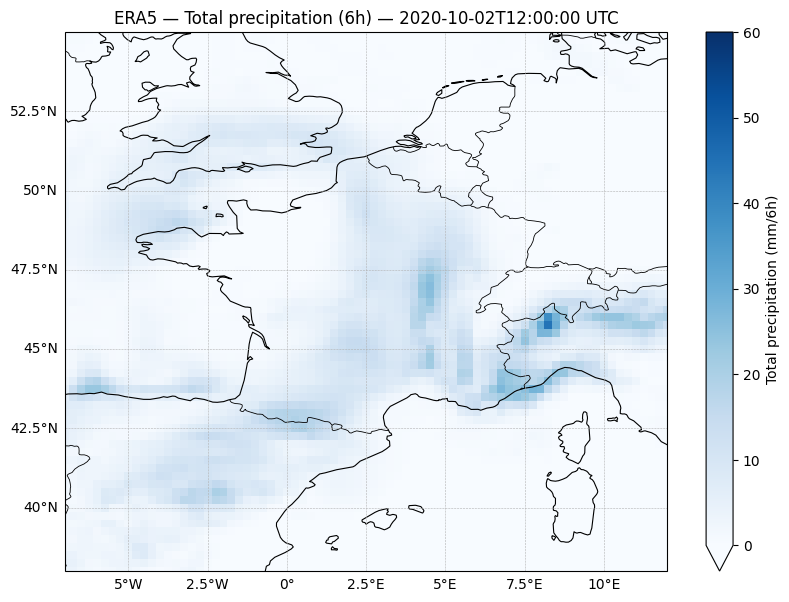

In [25]:
plot_era5_precip(ds,date,region=(-7, 12, 38,55))

In [36]:
make_gif("visuels_era5/precipitations/alex/europe", "alex_europe.gif",fps=2)
make_gif("visuels_era5/precipitations/alex/france", "alex_france.gif",fps=2)

✅ GIF sauvegardé : alex_europe.gif
✅ GIF sauvegardé : alex_france.gif


### Total Cloud Cover

In [51]:
def plot_era5_tot_cloud_cover(ds, date, region=(-12.5, 42.5, 35,72), save_path=None):

    lon_min, lon_max, lat_min, lat_max = region

    # Sélection de la date et conversion en mm
    tot_cloud_cover = ds["total_cloud_cover"].sel(
        time=date, method="nearest", tolerance="3H"
    )

    # Recentrage des longitudes sur [-180, 180]
    tot_cloud_cover = tot_cloud_cover.assign_coords(
        longitude=(((tot_cloud_cover.longitude + 180) % 360) - 180)
    ).sortby("longitude")

    # Gestion de la discontinuité à 180°
    if lon_min < lon_max:
        tot_cloud_cover_region = tot_cloud_cover.sel(
            longitude=slice(lon_min, lon_max),
            latitude=slice(lat_max, lat_min)
        )
    else:
        tot_cloud_cover_left = tot_cloud_cover.sel(
            longitude=slice(lon_min, 180),
            latitude=slice(lat_max, lat_min)
        )
        tot_cloud_cover_right = tot_cloud_cover.sel(
            longitude=slice(-180, lon_max),
            latitude=slice(lat_max, lat_min)
        )
        tot_cloud_cover_region = xr.concat([tot_cloud_cover_left, tot_cloud_cover_right], dim="longitude")

    # ---- FIGURE FIXE POUR TOUTES LES IMAGES ----
    fig = plt.figure(figsize=(10, 7), dpi=150)  # taille fixe
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

    # Ajustement fixe des marges (évite bbox_inches="tight")
    plt.subplots_adjust(left=0.08, right=0.92, top=0.92, bottom=0.08)

    # Tracé
    im = tot_cloud_cover_region.plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        cmap="Blues",
        vmin=0, vmax=1,
        cbar_kwargs={"label": "Total Cloud Cover"}
    )

    # Côtes, frontières, grille
    ax.add_feature(cfeature.COASTLINE.with_scale("50m"), linewidth=0.8)
    ax.add_feature(cfeature.BORDERS.with_scale("50m"), linewidth=0.6)

    gl = ax.gridlines(draw_labels=True, linestyle="--", linewidth=0.4)
    gl.right_labels = False
    gl.top_labels = False

    plt.title(f"ERA5 — Total Cloud Cover — {str(tot_cloud_cover.time.values)[:19]} UTC")

    # Sauvegarde
    if save_path is not None:
        plt.savefig(save_path)  # Pas de bbox_inches="tight"
        plt.close(fig)
        print(f"Carte sauvegardée : {save_path}")
    else:
        plt.show()


#### Random date

In [52]:
date = "2012-05-25T15:00:00"

In [54]:
plot_era5_tot_cloud_cover(ds,date,save_path='visuels_era5/total_cloud_cover/total_cloud_cover_2012-05-25_europe.png')
plot_era5_tot_cloud_cover(ds,date,save_path='visuels_era5/total_cloud_cover/total_cloud_cover_2012-05-25_monde.png',region=(-180,180,-90,90))

c:\Users\arfib\anaconda3\envs\meteo_env\Lib\site-packages\xarray\core\indexes.py:631: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  flat_indexer = index.get_indexer(flat_labels, method=method, tolerance=tolerance)


Carte sauvegardée : visuels_era5/total_cloud_cover/total_cloud_cover_2012-05-25_europe.png


c:\Users\arfib\anaconda3\envs\meteo_env\Lib\site-packages\xarray\core\indexes.py:631: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  flat_indexer = index.get_indexer(flat_labels, method=method, tolerance=tolerance)


Carte sauvegardée : visuels_era5/total_cloud_cover/total_cloud_cover_2012-05-25_monde.png


#### Tempête Alex

In [ ]:
dates = pd.date_range("2020-09-30", "2020-10-04", freq="6H")

# Créer les cartes toutes les 6h
for date in dates:
    iso_date = date.strftime("%Y-%m-%dT%H:%M:%S")  # garder l'heure réelle
    output_path_europe = f"visuels_era5/total_cloud_cover/alex/europe/tot_cc_{date.strftime('%Y%m%d_%H%M')}_europe.png"
    output_path_france = f"visuels_era5/total_cloud_cover/alex/france/tot_cc_{date.strftime('%Y%m%d_%H%M')}_france.png"
    
    plot_era5_tot_cloud_cover(
        ds,
        iso_date,
        save_path=output_path_europe
    )
    plot_era5_tot_cloud_cover(
        ds,
        iso_date,
        region=(-7, 12, 38,55),
        save_path=output_path_france
    )


In [57]:
make_gif("visuels_era5/total_cloud_cover/alex/europe", "clouds_alex_europe.gif",fps=2)
make_gif("visuels_era5/total_cloud_cover/alex/france", "clouds_alex_france.gif",fps=2)

✅ GIF sauvegardé : clouds_alex_europe.gif
✅ GIF sauvegardé : clouds_alex_france.gif


### Vent

In [62]:
ds["10m_u_component_of_wind"]

<xarray.DataArray '10m_u_component_of_wind' (time: 93544, latitude: 721,
                                             longitude: 1440)> Size: 388GB
dask.array<open_dataset-10m_u_component_of_wind, shape=(93544, 721, 1440), dtype=float32, chunksize=(1, 721, 1440), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 748kB 1959-01-01 ... 2023-01-10T18:00:00
  * latitude   (latitude) float32 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float32 6kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
Attributes:
    long_name:   10 metre U wind component
    short_name:  u10
    units:       m s**-1

In [60]:
ds

<xarray.Dataset> Size: 89TB
Dimensions:                                           (time: 93544,
                                                       latitude: 721,
                                                       longitude: 1440,
                                                       level: 13)
Coordinates:
  * time                                              (time) datetime64[ns] 748kB ...
  * latitude                                          (latitude) float32 3kB ...
  * longitude                                         (longitude) float32 6kB ...
  * level                                             (level) int64 104B 50 ....
Data variables: (12/62)
    10m_u_component_of_wind                           (time, latitude, longitude) float32 388GB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    10m_v_component_of_wind                           (time, latitude, longitude) float32 388GB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    10m_wind_speed                                    (time, latitude, longitude) float32 388GB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    2m_dewpoint_temperature                           (time, latitude, longitude) float32 388GB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    2m_temperature                                    (time, latitude, longitude) float32 388GB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    above_ground                                      (time, level, latitude, longitude) float32 5TB dask.array<chunksize=(1, 13, 721, 1440), meta=np.ndarray>
    ...                                                ...
    volumetric_soil_water_layer_1                     (time, latitude, longitude) float32 388GB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    volumetric_soil_water_layer_2                     (time, latitude, longitude) float32 388GB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    volumetric_soil_water_layer_3                     (time, latitude, longitude) float32 388GB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    volumetric_soil_water_layer_4                     (time, latitude, longitude) float32 388GB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    vorticity                                         (time, level, latitude, longitude) float32 5TB dask.array<chunksize=(1, 13, 721, 1440), meta=np.ndarray>
    wind_speed                                        (time, level, latitude, longitude) float32 5TB dask.array<chunksize=(1, 13, 721, 1440), meta=np.ndarray>

### Above ground

In [80]:
def plot_era5_above_ground(ds, date, level=None, region=(-12.5, 42.5, 35,72), save_path=None):
    """
    Affiche le total des précipitations sur 6h depuis un dataset ERA5 pour une date et un niveau donnés.

    Paramètres
    ----------
    ds : xarray.Dataset
        Dataset ERA5 contenant la variable 'above_ground'.
    date : str
        Date au format ISO (ex. '2012-08-25T15:00:00').
    level : int ou float, optionnel
        Niveau à sélectionner (ex. 2 pour 2 m au-dessus du sol). Si None, prend le premier niveau disponible.
    region : tuple (lon_min, lon_max, lat_min, lat_max), optionnel
        Limites géographiques de la carte.
    save_path : str ou None, optionnel
        Chemin complet du fichier PNG à sauvegarder.
    """

    lon_min, lon_max, lat_min, lat_max = region

    # Sélection de la date et du niveau
    if level is not None:
        precip = ds["above_ground"].sel(time=date, method="nearest", tolerance="3H") * 1000
        precip= precip.sel(level=level)
    else:
        # Si pas de level spécifié, prend le premier niveau
        if "level" in ds["above_ground"].dims:
            precip = ds["above_ground"].isel(level=0).sel(time=date, method="nearest", tolerance="3H") * 1000
        else:
            precip = ds["above_ground"].sel(time=date, method="nearest", tolerance="3H") * 1000

    # Recentrage longitudes
    precip = precip.assign_coords(longitude=(((precip.longitude + 180) % 360) - 180)).sortby("longitude")

    # Gestion discontinuité 180°
    if lon_min < lon_max:
        precip_region = precip.sel(longitude=slice(lon_min, lon_max), latitude=slice(lat_max, lat_min))
    else:
        precip_left = precip.sel(longitude=slice(lon_min, 180), latitude=slice(lat_max, lat_min))
        precip_right = precip.sel(longitude=slice(-180, lon_max), latitude=slice(lat_max, lat_min))
        precip_region = xr.concat([precip_left, precip_right], dim="longitude")

    # Tracé
    proj = ccrs.PlateCarree()
    fig = plt.figure(figsize=(10, 7))
    ax = plt.axes(projection=proj)
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=proj)

    im = precip_region.plot(
        ax=ax, transform=proj, cmap="Blues",
        vmin=0, vmax=float(precip_region.max()),
        cbar_kwargs={"label": "Total precipitation (mm/6h)"}
    )

    ax.add_feature(cfeature.COASTLINE.with_scale("50m"), linewidth=0.8)
    ax.add_feature(cfeature.BORDERS.with_scale("50m"), linewidth=0.6)
    gl = ax.gridlines(draw_labels=True, linestyle="--", linewidth=0.4)
    gl.right_labels = False
    gl.top_labels = False

    plt.title(f"ERA5 — Total precipitation (6h) — {str(precip.time.values)[:19]} UTC")
    
    if save_path is not None:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
        plt.close(fig)
        print(f"Carte sauvegardée : {save_path}")
    else:
        plt.show()


In [81]:
def plot_era5_per_level(ds, date, region=(-12.5, 42.5, 35,72), save_dir=None):
    """
    Affiche les précipitations sur 6h pour tous les niveaux présents dans 'above_ground'.

    Paramètres
    ----------
    ds : xarray.Dataset
        Dataset ERA5 contenant la variable 'above_ground'.
    date : str
        Date au format ISO.
    region : tuple (lon_min, lon_max, lat_min, lat_max), optionnel
        Limites géographiques de la carte.
    save_dir : str ou None, optionnel
        Répertoire où sauvegarder les cartes (si None, affiche les cartes à l'écran).
    """

    if "level" not in ds["above_ground"].dims:
        # Pas de dimension level, juste plot normal
        plot_era5_above_ground(ds, date, level=None, region=region, save_path=None)
        return

    levels = ds["above_ground"].level.values
    for lev in levels:
        save_path = f"{save_dir}/precip_level_{lev}.png" if save_dir else None
        print(f"Plotting level {lev}")
        plot_era5_above_ground(ds, date, level=lev, region=region, save_path=save_path)


In [86]:
date = "2012-08-25T15:00:00"

Plotting level 50


c:\Users\arfib\anaconda3\envs\meteo_env\Lib\site-packages\xarray\core\indexes.py:631: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  flat_indexer = index.get_indexer(flat_labels, method=method, tolerance=tolerance)


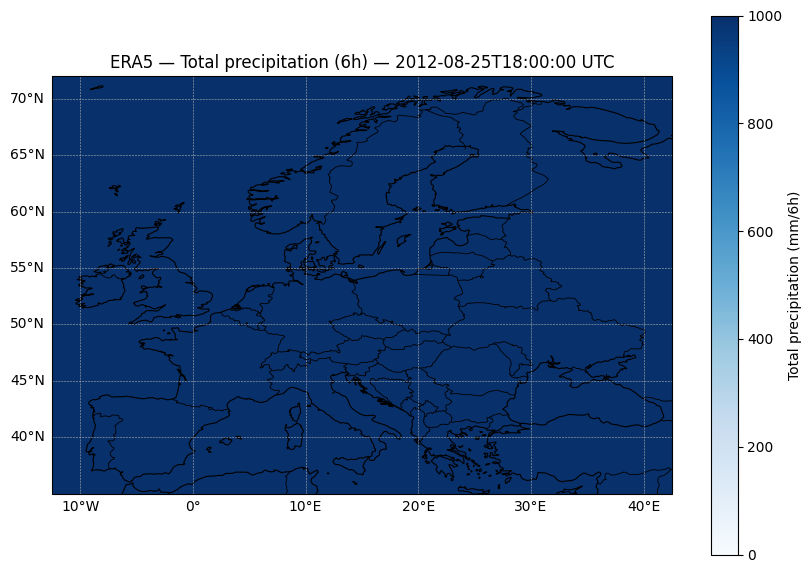

Plotting level 100


c:\Users\arfib\anaconda3\envs\meteo_env\Lib\site-packages\xarray\core\indexes.py:631: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  flat_indexer = index.get_indexer(flat_labels, method=method, tolerance=tolerance)


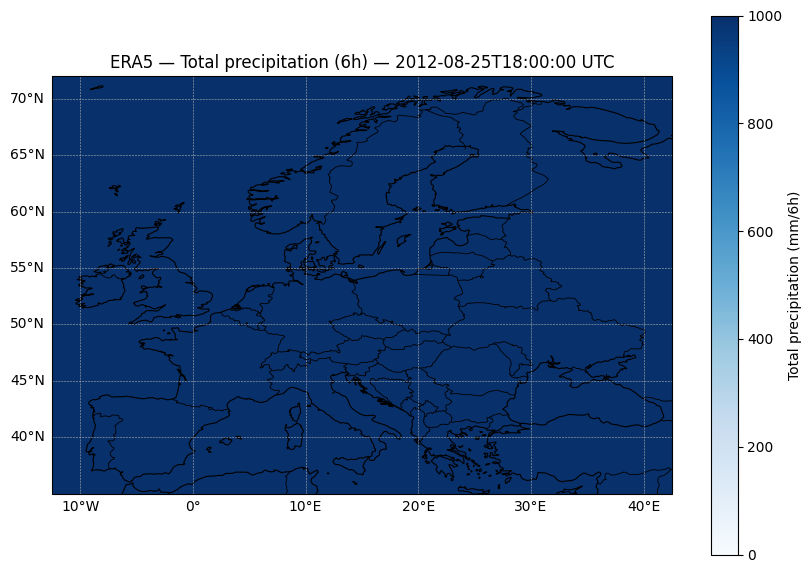

Plotting level 150


c:\Users\arfib\anaconda3\envs\meteo_env\Lib\site-packages\xarray\core\indexes.py:631: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  flat_indexer = index.get_indexer(flat_labels, method=method, tolerance=tolerance)


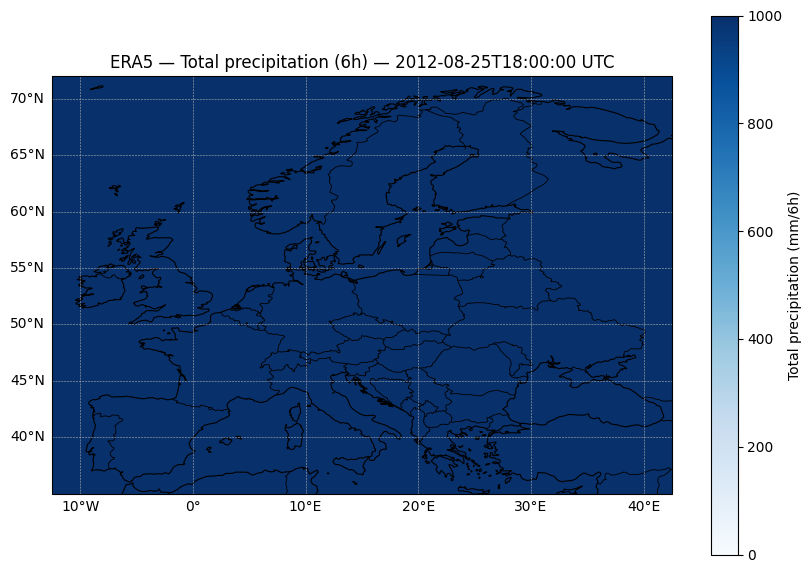

Plotting level 200


c:\Users\arfib\anaconda3\envs\meteo_env\Lib\site-packages\xarray\core\indexes.py:631: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  flat_indexer = index.get_indexer(flat_labels, method=method, tolerance=tolerance)


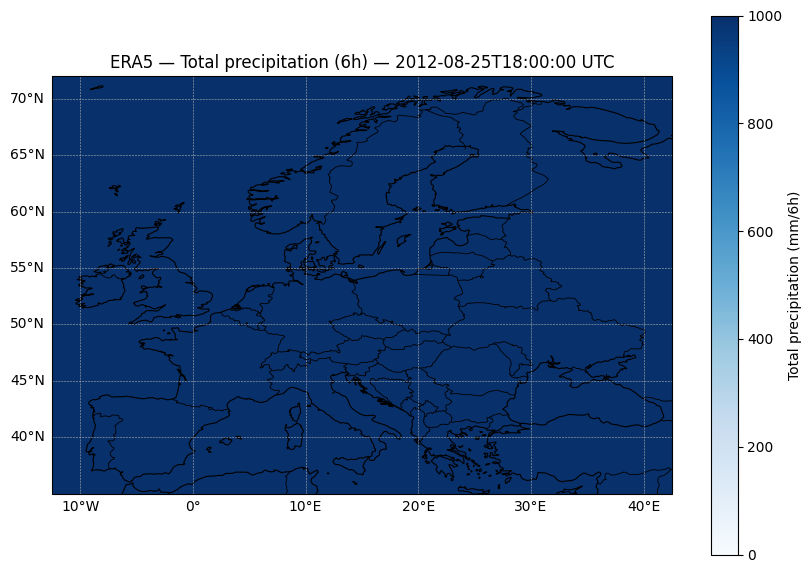

Plotting level 250


c:\Users\arfib\anaconda3\envs\meteo_env\Lib\site-packages\xarray\core\indexes.py:631: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  flat_indexer = index.get_indexer(flat_labels, method=method, tolerance=tolerance)


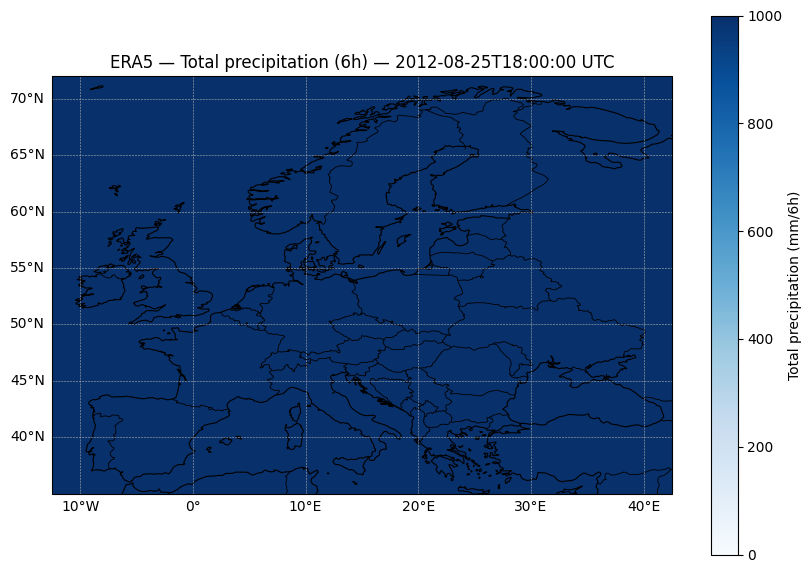

Plotting level 300


c:\Users\arfib\anaconda3\envs\meteo_env\Lib\site-packages\xarray\core\indexes.py:631: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  flat_indexer = index.get_indexer(flat_labels, method=method, tolerance=tolerance)


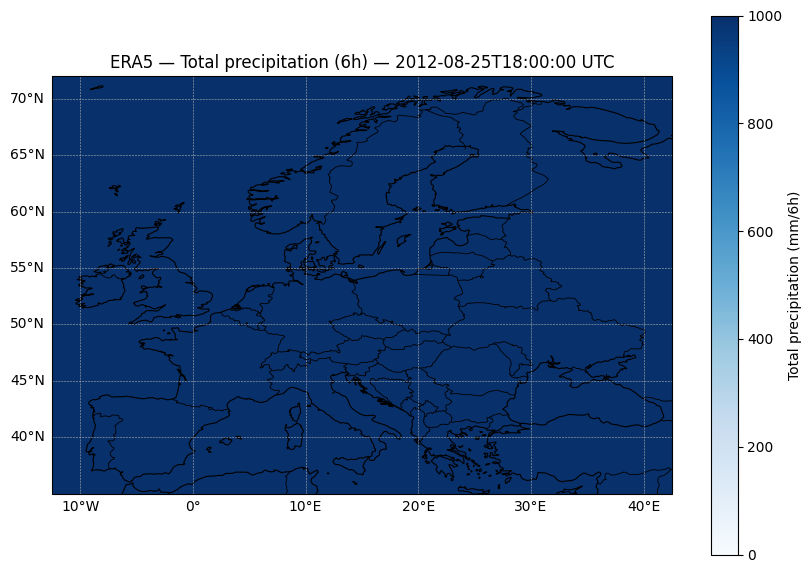

Plotting level 400


c:\Users\arfib\anaconda3\envs\meteo_env\Lib\site-packages\xarray\core\indexes.py:631: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  flat_indexer = index.get_indexer(flat_labels, method=method, tolerance=tolerance)


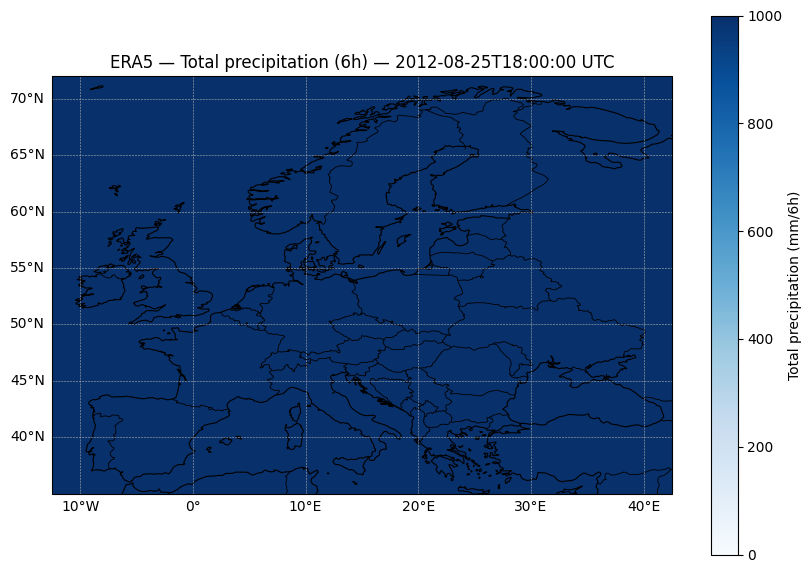

Plotting level 500


c:\Users\arfib\anaconda3\envs\meteo_env\Lib\site-packages\xarray\core\indexes.py:631: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  flat_indexer = index.get_indexer(flat_labels, method=method, tolerance=tolerance)


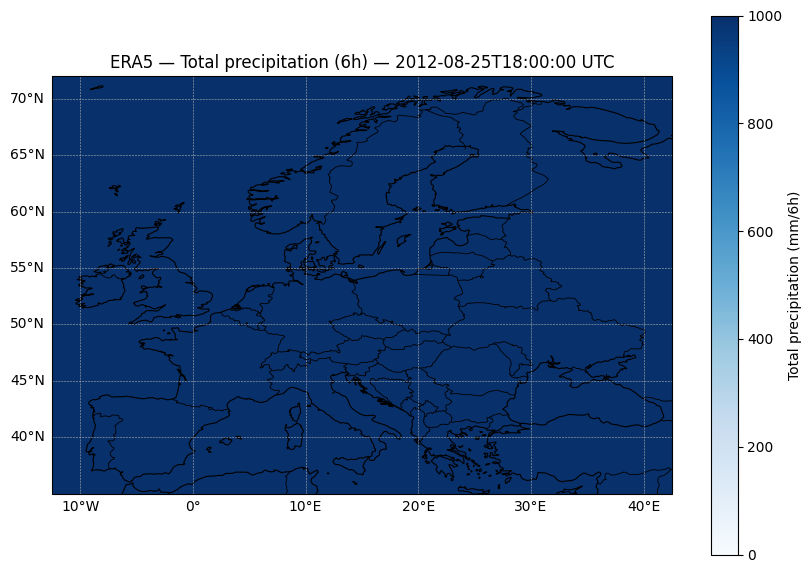

Plotting level 600


c:\Users\arfib\anaconda3\envs\meteo_env\Lib\site-packages\xarray\core\indexes.py:631: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  flat_indexer = index.get_indexer(flat_labels, method=method, tolerance=tolerance)


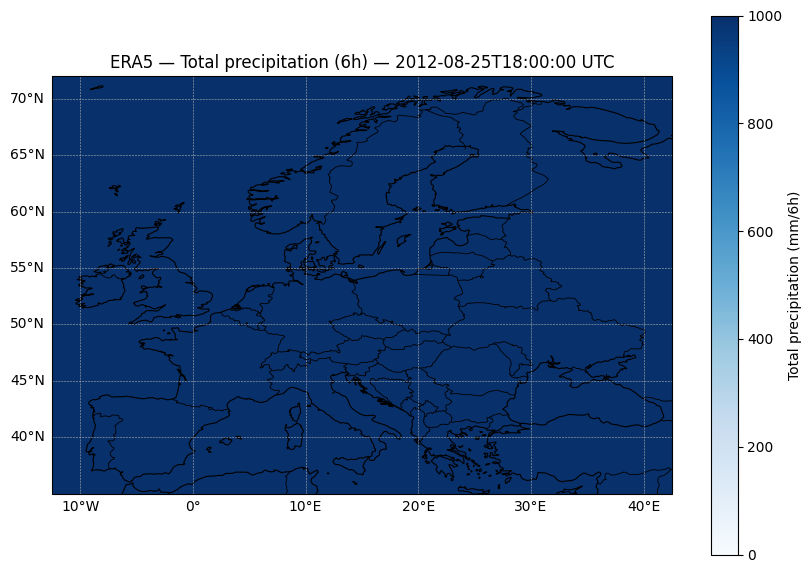

Plotting level 700


c:\Users\arfib\anaconda3\envs\meteo_env\Lib\site-packages\xarray\core\indexes.py:631: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  flat_indexer = index.get_indexer(flat_labels, method=method, tolerance=tolerance)


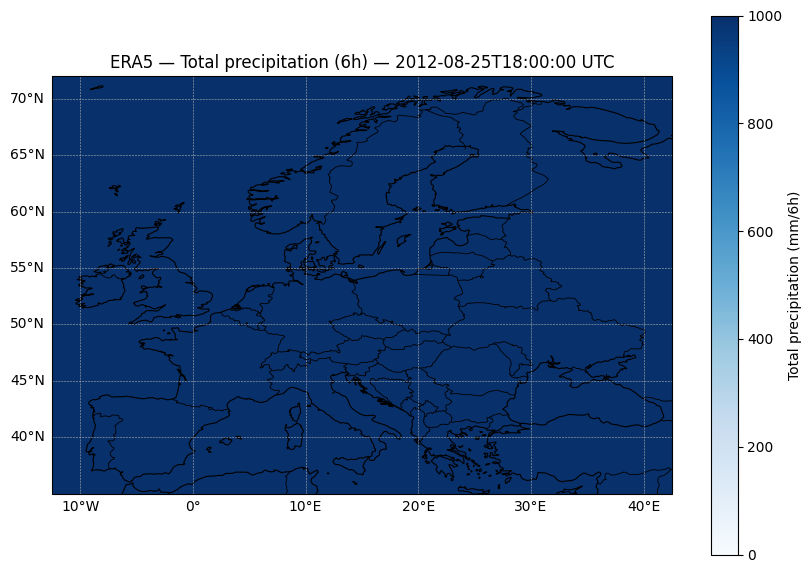

Plotting level 850


c:\Users\arfib\anaconda3\envs\meteo_env\Lib\site-packages\xarray\core\indexes.py:631: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  flat_indexer = index.get_indexer(flat_labels, method=method, tolerance=tolerance)


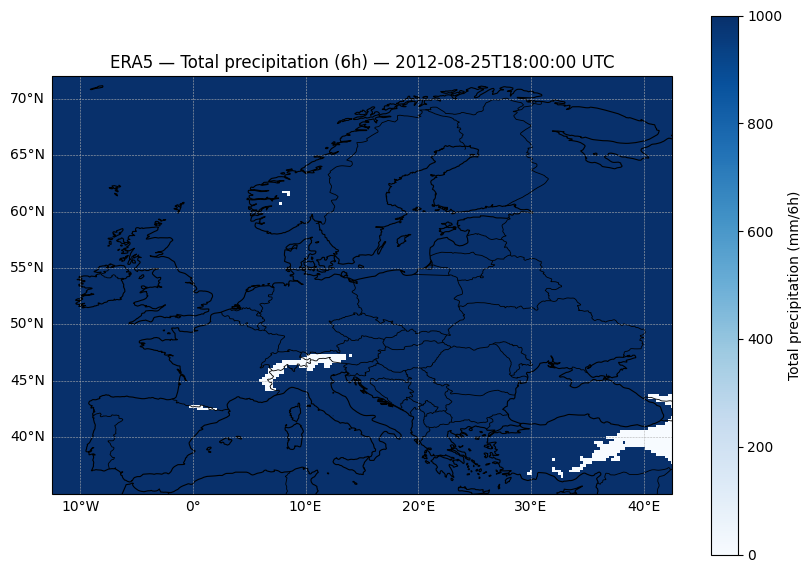

Plotting level 925


c:\Users\arfib\anaconda3\envs\meteo_env\Lib\site-packages\xarray\core\indexes.py:631: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  flat_indexer = index.get_indexer(flat_labels, method=method, tolerance=tolerance)


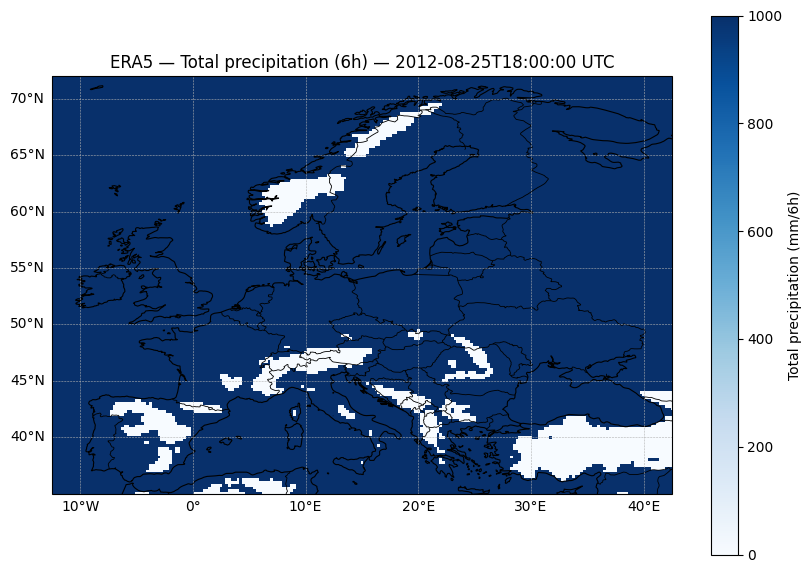

Plotting level 1000


c:\Users\arfib\anaconda3\envs\meteo_env\Lib\site-packages\xarray\core\indexes.py:631: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  flat_indexer = index.get_indexer(flat_labels, method=method, tolerance=tolerance)


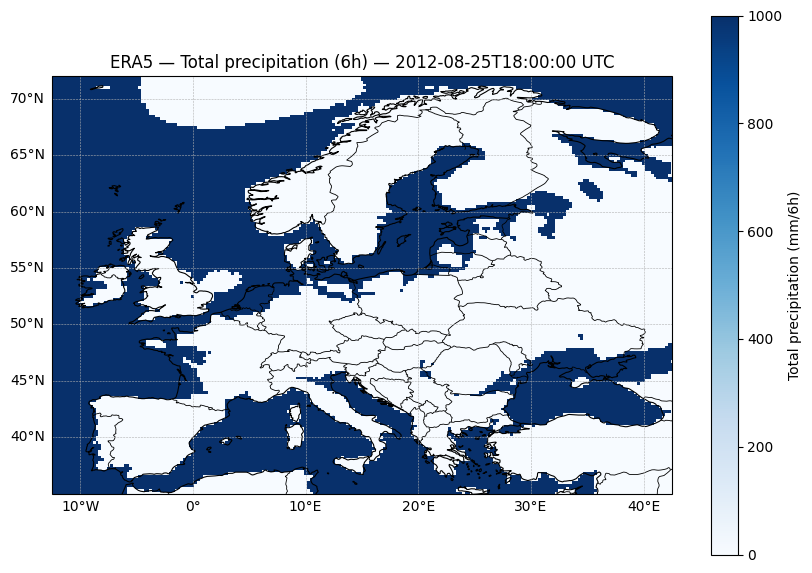

In [87]:
plot_era5_per_level(ds,date)